In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import umap

In [3]:
from typing import List

In [4]:
import matplotlib.pyplot as plt

In [5]:
from birdsong_gan.models.generative_model import GaussHMMGAN

In [6]:
from birdsong_gan.utils.utils import rescale_spectrogram

In [7]:
import pdb

In [8]:
def plot_spectrograms(spectrograms: List[np.ndarray], figsize=(20,15)):
    
    fig, ax = plt.subplots(nrows=len(spectrograms), figsize=figsize)
    for i in range(len(spectrograms)):
        ax[i].imshow(rescale_spectrogram(spectrograms[i]), origin='lower', cmap='gray')
    
    return fig

# load model

In [9]:
model = GaussHMMGAN(netGpath='/home/gagan/zudeep/models/daily_gan/p20r16_nz12_alldaysnets/netG_epoch_40_day_all.pth',
                   netEpath='/home/gagan/zudeep/models/daily_gan/p20r16_nz12_alldaysnets/netE_epoch_40_day_all.pth',
                   hmmpath='/home/gagan/zudeep/models/daily_gan/p20r16_nz12_alldaysnets/day_14/hmm_hiddensize_100/model_day_14.pkl',
                   ngf=128)

In [10]:
model.netG = model.netG.eval()

In [11]:
model.netE = model.netE.eval()

## sample spectrograms from it

In [27]:
X = model.sample(nsamples=10, invtemp=1., timesteps=[64 for _ in range(10)], cuda=True)

/home/gagan/code/birdsong_gan/birdsong_gan/hmm/hmm_utils.py:57: RuntimeWarning: divide by zero encountered in log
  p = np.exp(beta * np.log(a))


In [33]:
len(X)

10

In [29]:
X[0].shape

(129, 1024)

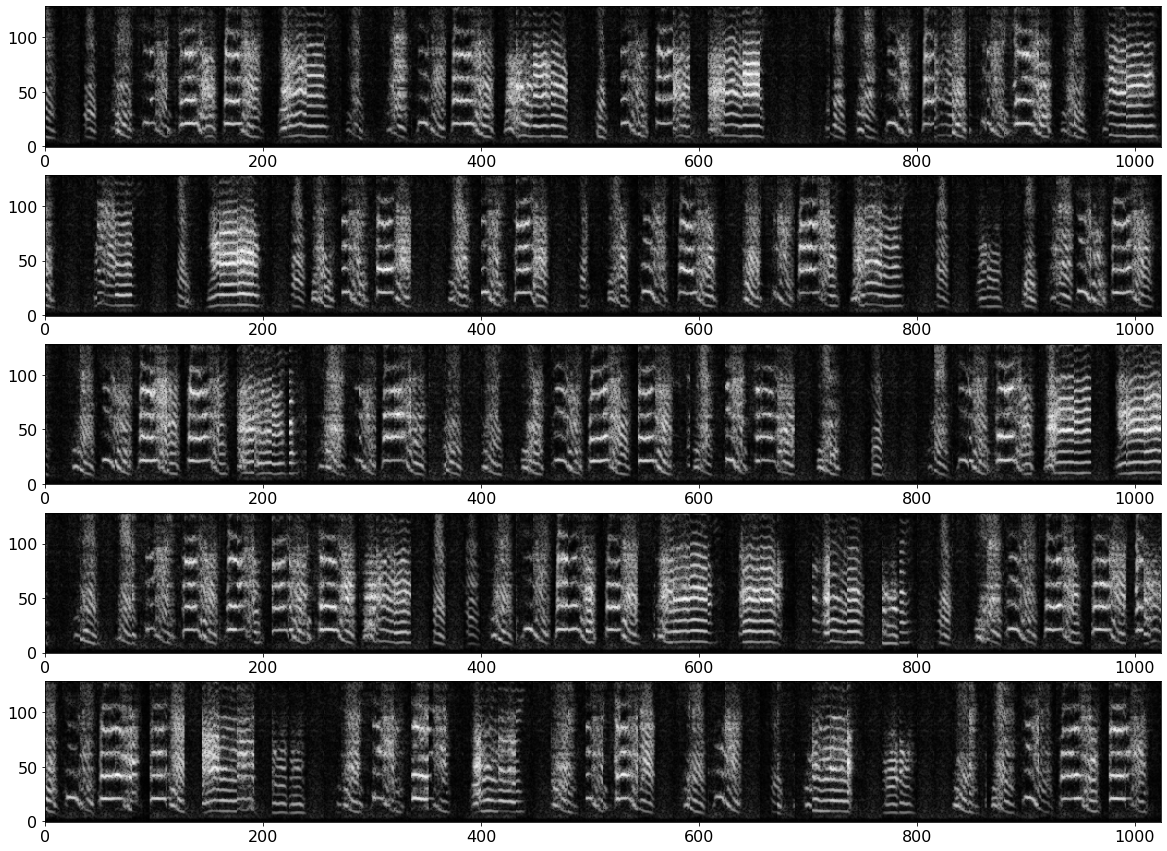

In [30]:
fig = plot_spectrograms(X[:5])

In [31]:
audio = model.generate_audio(X)

In [36]:
audio = audio[10:]

In [39]:
from IPython.display import display, Audio

In [38]:
display(Audio(audio[6], rate=16000))

In [23]:
#model = None
#torch.cuda.empty_cache()

## compute pitch

In [12]:
import librosa as lc

In [49]:
f0, voiced_flag, voiced_probs = lc.pyin(audio[0],sr=16000,fmin=100.,fmax=8000., frame_length=512, win_length=256, hop_length=128, switch_prob=0.1, fill_na=np.nan)

In [66]:
times = lc.frames_to_time(1,sr=16000,hop_length=128)
times

0.008

In [63]:
def get_pitch_and_vocal_segments(audio, sr=16000,fmin=100.,fmax=8000., frame_length=512, win_length=256, hop_length=128, switch_prob=0.1, fill_na=np.nan):
    f0, voiced_frames, _ = lc.pyin(audio, sr=sr, fmin=fmin, fmax=fmax, frame_length=frame_length,
                                   win_length=win_length, hop_length=hop_length, switch_prob=switch_prob, fill_na=fill_na)
    return f0, voiced_frames
                                 
                                 
                                 

def get_durations_from_vocal_segments(voiced_frames, min_dur = 3):
    
    onsets = np.where(np.diff(voiced_frames) > 0.)[0]
    offsets = np.where(np.diff(voiced_frames) < 0.)[0]
    
    if len(onsets)==0 or len(offsets)==0:
        return None, None, None, None, None
    
    ON = onsets
    OFF = offsets
    
    # lengths off by 1
    if np.abs(len(onsets)-len(offsets)) == 1:
        if offsets[0] < onsets[0]:
            OFF = offsets[1:]
        elif onsets[-1] > offsets[-1]:
            ON = onsets[:-1]
            
    vocal_segs = []
    durations = []
    gap_lengths = []
    gap_start = 0
    to_remove = []
    
    if len(ON)==0 or len(OFF)!=len(ON):
        return None,None,None,None,None
    
    
    for k in range(len(OFF)):
        
        if OFF[k] - ON[k] >= min_dur:
            vocal_segs.append(voiced_frames[ON[k] : OFF[k]])
            durations.append(OFF[k] - ON[k])
            
        gap_lengths.append(ON[k]-gap_start)
        gap_start = OFF[k]
        
    return vocal_segs, durations, gap_lengths, onsets, offsets



def get_pitch_duration_gaps(audio_waveforms, pitch_kwargs, min_vocal_duration=3, log_every=10):
    
    pitches = []
    durations = []
    gap_lengths = []
    for i, audio in enumerate(audio_waveforms):
        
        f0, voiced_frames = get_pitch_and_vocal_segments(audio, **pitch_kwargs)
        
        vframes = np.ones(len(voiced_frames))
        vframes[voiced_frames==False] = 0.
        
        if len(voiced_frames == 1.) < min_vocal_duration:
            continue 
            
        _, durs, gaps, _, _ = get_durations_from_vocal_segments(vframes, min_vocal_duration)
    
        if durs is None:
            continue
            
        durs = np.array([lc.frames_to_time(d, sr=pitch_kwargs['sr'], hop_length=pitch_kwargs['hop_length']) for d in durs])
        gaps = np.array([lc.frames_to_time(g, sr=pitch_kwargs['sr'], hop_length=pitch_kwargs['hop_length']) for g in gaps])
        
        durations.append(durs)
        gap_lengths.append(gaps)
        pitches.append(f0[np.isnan(f0)==False])
        
        if i%log_every==0:
            print(f"Done with {i}/{len(audio_waveforms)}")
            
    return pitches, durations, gap_lengths





# Get real data

In [14]:
from birdsong_gan.data.dataset import bird_dataset_single_hdf

In [15]:
dataset = bird_dataset_single_hdf('/home/gagan/zudeep/all_birds.hdf', 'p20r16')

... total number of folders for bird p20r16 = 35 ...


In [16]:
dataset.ndays

35

In [17]:
# choose a day
Xreal = dataset.get(day=14, nsamps=-1)

In [18]:
Xtutor = dataset.get(day='tutor', nsamps=-1)

In [20]:
len(Xreal)

1603

In [21]:
Xreal[0].shape

(129, 326)

# Make real and sample audios

In [22]:
Xsamp = model.sample(nsamples=len(Xreal), timesteps=[x.shape[1]//16 for x in Xreal], cuda=True)


/home/gagan/code/birdsong_gan/birdsong_gan/hmm/hmm_utils.py:57: RuntimeWarning: divide by zero encountered in log
  p = np.exp(beta * np.log(a))


### get audio from real spectrograms

In [23]:
real_audios = model.generate_audio(Xreal)

In [24]:
sample_audios = model.generate_audio(Xsamp)

In [25]:
len(sample_audios)

1603

# Extract pitch and durations

First for real data

In [ ]:
pitches_real, durations_real, gap_lengths_real = get_pitch_duration_gaps(real_audios, dict(sr=16000,fmin=100.,fmax=8000.,
                                                                                          frame_length=512, win_length=256,
                                                                                          hop_length=128, switch_prob=0.1,
                                                                                          fill_na=np.nan), min_vocal_duration=3)


In [69]:
pitches_real_ = np.concatenate(pitches_real)
pitches_real_.shape

durations_real_ = np.concatenate(durations_real)
durations_real_.shape

gaps_real = np.concatenate(gap_lengths_real)
gaps_real.shape

Then, for samples

In [ ]:
pitches_samp, durations_samp, gap_lengths_samp = get_pitch_duration_gaps(sample_audios, dict(sr=16000,fmin=100.,fmax=8000.,
                                                                                          frame_length=512, win_length=256,
                                                                                          hop_length=128, switch_prob=0.1,
                                                                                          fill_na=np.nan), min_vocal_duration=3)

In [73]:
durations_samp_ = np.concatenate(durations_samp)
gaps_samp = np.concatenate(gap_lengths_samp)
len(gaps_samp)

23158

In [74]:
pitches_samp_ = np.concatenate(pitches_samp)
pitches_samp_.shape

(200416,)

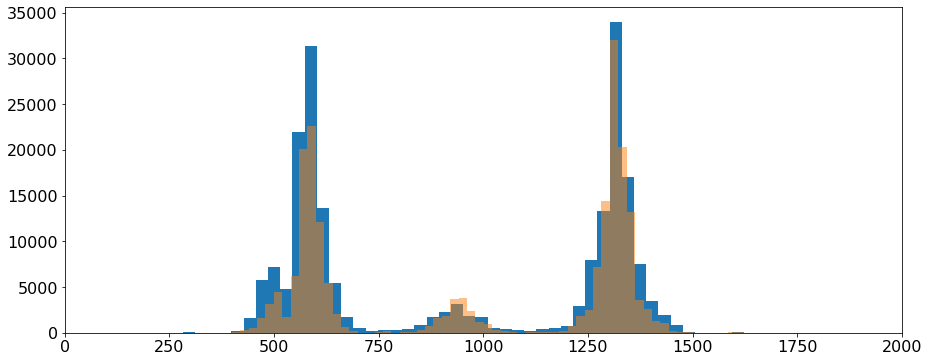

In [77]:
plt.figure(figsize=(15,6))
plt.hist(pitches_real_, bins=200)
plt.hist(pitches_samp_, bins=200, alpha=0.5)
plt.xlim([0, 2000])
plt.show()

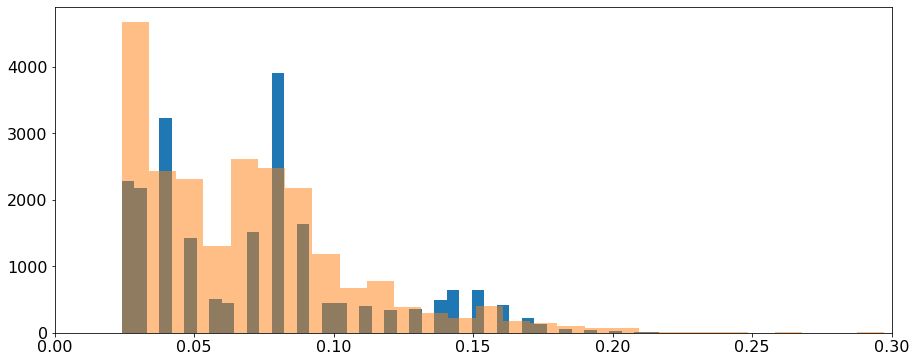

In [81]:
plt.figure(figsize=(15,6))
plt.hist(durations_real_, bins=50)
plt.hist(durations_samp_, bins=50, alpha=0.5)
plt.xlim([0, 0.3])
plt.show()

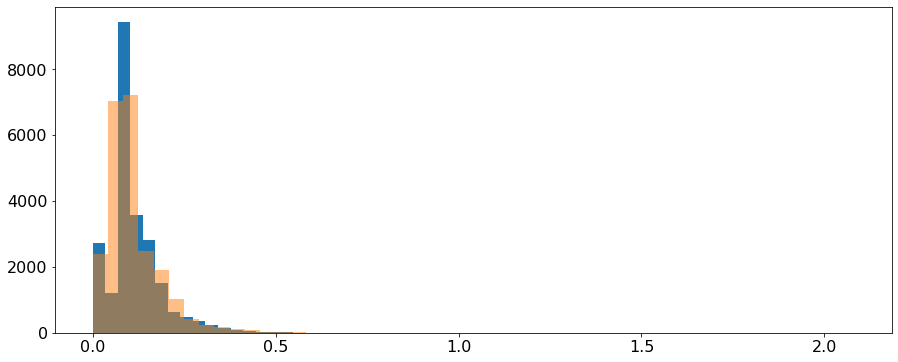

In [80]:
plt.figure(figsize=(15,6))
plt.hist(gaps_real, bins=50)
plt.hist(gaps_samp, bins=50, alpha=0.5)
#plt.xlim([0, 2000])
plt.show()

# Statistical test

In [82]:
from scipy.stats import ks_2samp, wilcoxon, mannwhitneyu

In [83]:
ks_2samp(pitches_real_, pitches_samp_)

KstestResult(statistic=0.07401582035607107, pvalue=0.0)